In [8]:
u.user <- read.csv(file='u.user.csv', sep='|', header=T)
u.item <- read.csv(file='u.item.csv', sep='|', header=T)
u.data <- read.csv(file='u.data.csv', sep='|', header=T)
library(Matrix)
m.sparse <- sparseMatrix(u.data[,1],u.data[,2],x=u.data[,3])
rownames(m.sparse) <- paste('u', 1:nrow(m.sparse), sep='')
colnames(m.sparse) <- paste('i', 1:ncol(m.sparse), sep='')
mae <- function(m1, m2) mean(abs(m1 - m2), na.rm=T)

m <- as.matrix(m.sparse)                # transforme en matrice ordinaire
m.na <- m
m.na[m.na==0] <- NA

On regarde la distribution des votes

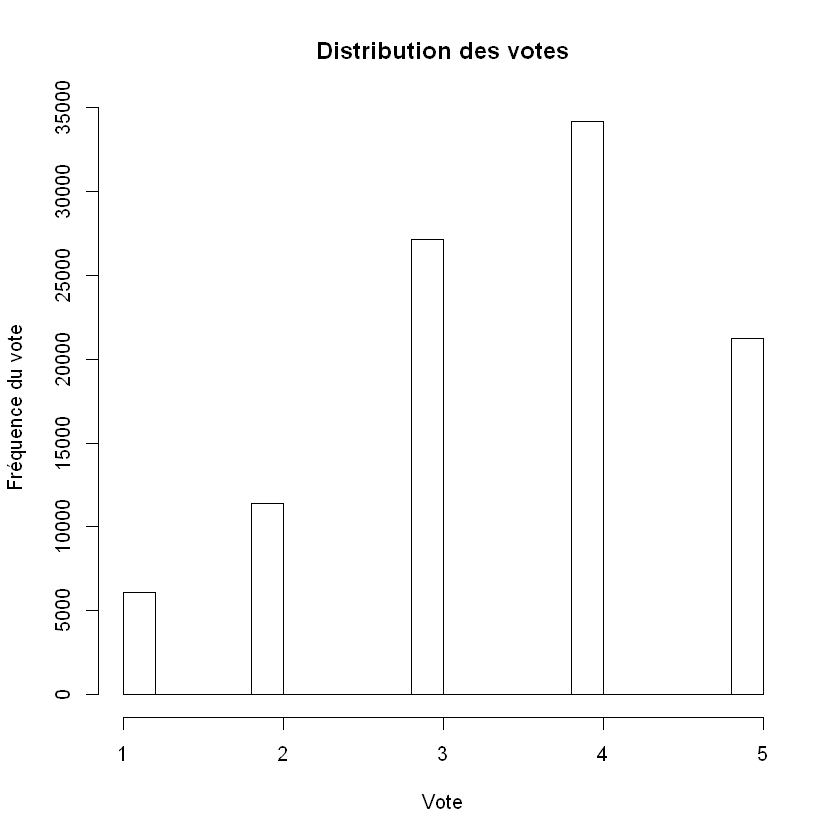

In [9]:
hist.values <- hist(u.data$rating, main = 'Distribution des votes',xlab = 'Vote',ylab = 'Fréquence du vote')

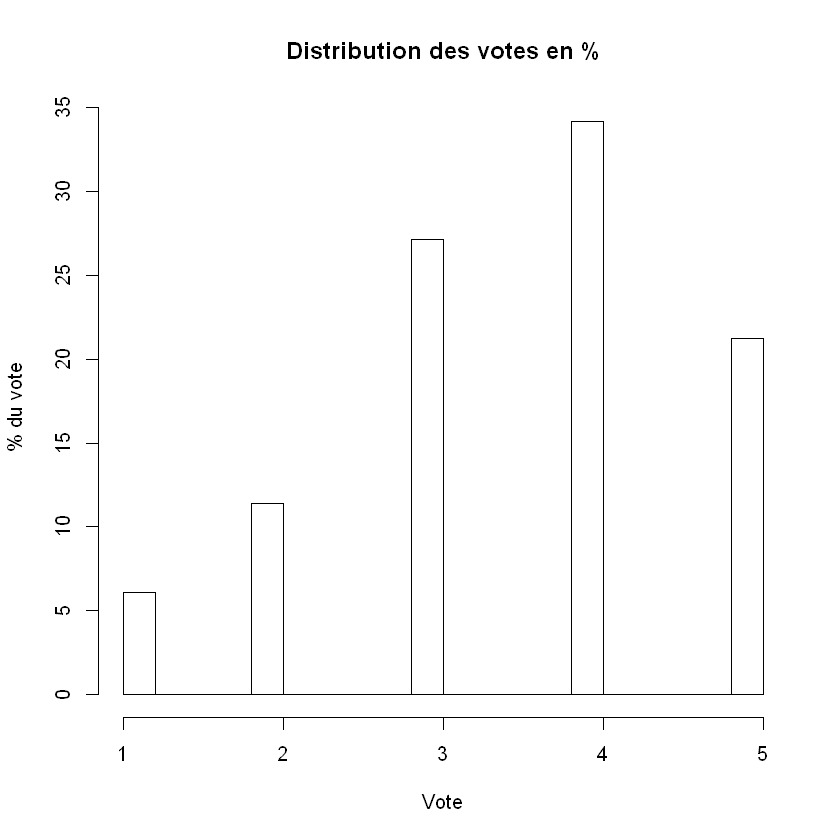

In [10]:
hist.values$density = hist.values$counts/sum(hist.values$counts)*100
plot(hist.values,freq=FALSE,main = 'Distribution des votes en %',xlab = 'Vote',ylab = '% du vote')

Probabilités de chaque vote

In [11]:
hist.prob <- round(100*hist.values$counts/sum(hist.values$counts))

Création des données avec la distribution déjà existante

In [12]:
rand.dist <- rep(1,6*16000)
rand.dist <- c(rand.dist, rep(2,11*16000))
rand.dist <- c(rand.dist, rep(3,27*16000))
rand.dist <- c(rand.dist, rep(4,34*16000))
rand.dist <- c(rand.dist, rep(5,21*16000))

In [13]:
new.m.cv <- function(dimRedu){
# matrice diagonale pour réduire les matrices originales
m.d2 <- diag(c(m.svd$d[1:dimRedu],rep(0,length(m.svd$d)-dimRedu)))
# nouvelle matrice basée sur les deux premières dimensions uniquement
m.svd2 <- round((m.svd$u %*% m.d2 %*% t(m.svd$v)),2)
mae(m.svd2[i.test.b], m.na[i.test.b])
    }
to.plot <- c()
cv.b <- c()

In [21]:
i.observed <- which(m > 0)
i.hasard <- sample(i.observed, length(i.observed))
fold.size <- round(length(i.hasard) / 5)
i.false <- rep(FALSE, length(m))
for (i in seq_len(5)){
fold.number <- i

## Index booléen pour les cellules de test et d'entraînement
i.test.b <- i.false
## Les cellules indexées du replis correspondant sont fixées à TRUE pour le test...
i.test.b[ i.hasard[((fold.number-1) * fold.size):((fold.number) * fold.size)] ] <- TRUE
## ...et à FALSE pour l'entraînement
i.train.b <-  !i.test.b
m.train <- m
m.train[i.test.b] <- 0                # on enlève les données de test pour l'entraînement
m.train[m.train==0] <-sample(rand.dist,sum(m.train==0))
cv.b <- c(cv.b,mae(m.train[i.test.b],m[i.test.b]))
m.svd <- svd(m.train)
to.plot<-rbind(to.plot,unlist(lapply(seq(22), new.m.cv)))
    }


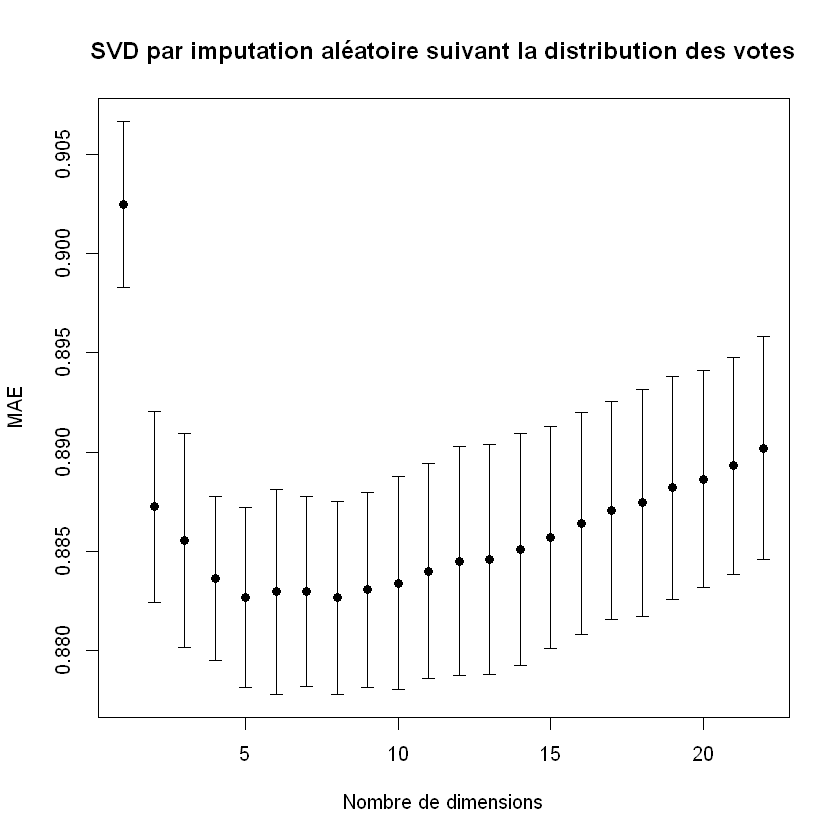

In [24]:
to.plot<-apply(to.plot,2,unlist)
sdev <- apply(to.plot,2,sd) 
avg <- colMeans(to.plot)
avg.cv <- mean(cv.b)
x <- 1:length(avg)
plot(x,colMeans(to.plot),ylim=range(avg-sdev, avg+sdev),pch=19, xlab="Nombre de dimensions", ylab="MAE",
    main="SVD par imputation aléatoire suivant la distribution des votes"
)
# hack: we draw arrows but with very special "arrowheads"
arrows(x, avg-sdev, x, avg+sdev, length=0.05, angle=90, code=3)

In [23]:
avg.cv

[1] 1.224951